In [2]:
# Import dependencies
import pandas as pd
import numpy as np
import sys
from anndata import AnnData
import scanpy as sc
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
import spatialcorr

warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Set data path
data_path = "D:/Desktop/MGI/CODE/"

In [4]:
# data
data = sc.read_h5ad(data_path + "Data/SS200000116BR_E6.bin200.h5ad")
data

AnnData object with n_obs × n_vars = 17574 × 30523
    obs: 'orig.ident', 'x', 'y'
    obsm: 'spatial'

In [5]:
# annotation data
cluster_data = pd.read_csv(data_path + "Output/seurat_cluster.csv", index_col=0)
cluster_data.index = cluster_data.index.rename('ID')
cluster_data.reset_index(inplace=True)
cluster_data.drop(['x', 'y'], axis=1, inplace=True)
cluster_data

,ID,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.5,seurat_clusters
0,29205777624400,sample,9076,3340,3.735126,5,5
1,31782757998200,sample,15168,4340,4.199631,5,5
2,32641751459800,sample,12591,3984,6.758796,5,5
3,43808666430600,sample,24901,6230,6.754749,4,4
4,44667659891800,sample,44307,8483,2.855079,4,4
...,...,...,...,...,...,...,...
8687,107374182424000,sample,6597,2511,2.364711,0,0
8688,98784247826200,sample,13930,4092,3.101220,0,0
8689,32641751461000,sample,11069,3666,5.854187,5,5
8690,78168404794000,sample,11042,3460,3.731208,0,0


In [6]:
data_obs = data.obs.copy()
data_obs.index = data_obs.index.rename('ID')
data_obs.reset_index(inplace=True)

data_obs['ID'] = data_obs['ID'].astype(str)
cluster_data['ID'] = cluster_data['ID'].astype(str)

merged_data = pd.merge(data_obs, cluster_data, on='ID', how='inner')
merged_data

,ID,orig.ident_x,x,y,orig.ident_y,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.5,seurat_clusters
0,29205777624400,sample,6800,11600,sample,9076,3340,3.735126,5,5
1,31782757998200,sample,7400,7800,sample,15168,4340,4.199631,5,5
2,32641751459800,sample,7600,10200,sample,12591,3984,6.758796,5,5
3,43808666430600,sample,10200,11400,sample,24901,6230,6.754749,4,4
4,44667659891800,sample,10400,13400,sample,44307,8483,2.855079,4,4
...,...,...,...,...,...,...,...,...,...,...
8687,107374182424000,sample,25000,24000,sample,6597,2511,2.364711,0,0
8688,98784247826200,sample,23000,18200,sample,13930,4092,3.101220,0,0
8689,32641751461000,sample,7600,11400,sample,11069,3666,5.854187,5,5
8690,78168404794000,sample,18200,6800,sample,11042,3460,3.731208,0,0


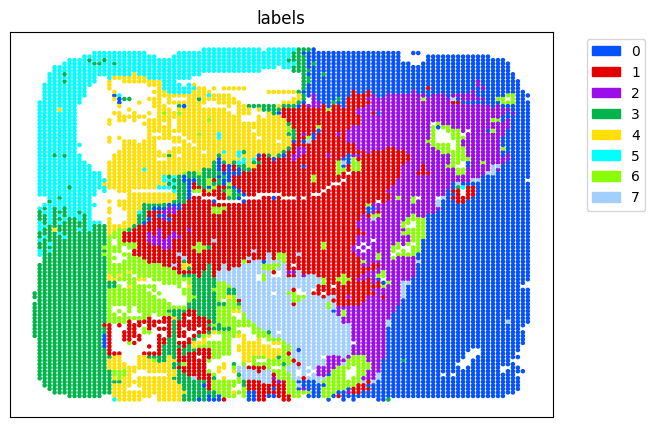

In [7]:
# Annotated region based on RCTD results
spatialcorr.plot_slide(
    merged_data, 
    merged_data['seurat_clusters'], 
    cmap='categorical', 
    colorbar=True,
    title="labels",
    row_key='y',
    col_key='x',
    ticks=False,
    dsize=5
    # spot_borders=True
)

In [8]:
# Dataframe to Anndata
merged_data_ann = AnnData(obs=merged_data, var=data.var)
aligned_X = data[data.obs.index.isin(merged_data_ann.obs["ID"])].X
merged_data_ann = AnnData(X=aligned_X.toarray(), obs=merged_data, var=data.var)
merged_data_ann

c:\Users\40868\AppData\Local\Programs\Python\Python39\lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
c:\Users\40868\AppData\Local\Programs\Python\Python39\lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 8692 × 30523
    obs: 'ID', 'orig.ident_x', 'x', 'y', 'orig.ident_y', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters'

Kept 0/8692 spots.


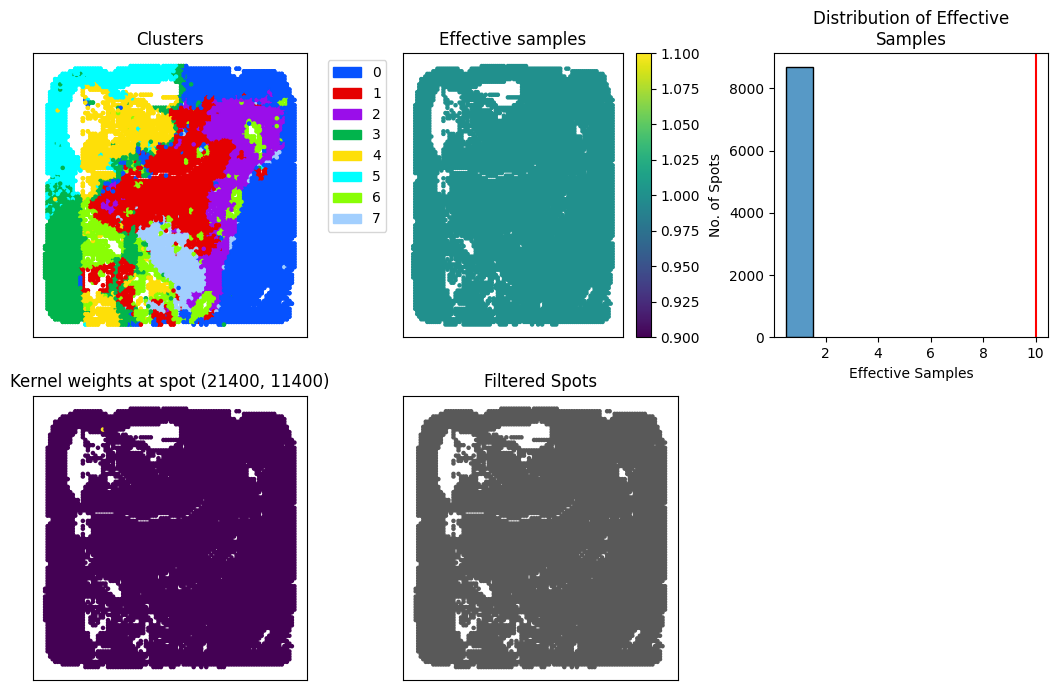

In [9]:
spatialcorr.wrappers.kernel_diagnostics(
    adata=merged_data_ann,
    cond_key='seurat_clusters',
    bandwidth=5,
    contrib_thresh=10,
    row_key='y',
    col_key='x',
    dsize=5,
    dpi=150
)

In [10]:
top10 = ["IGLC3", "IGLC2", "IGHA2", "IGHM", "IGLL5", "IGHG2", "IGHG3", "IGHA1", "JCHAIN", "IGLV3-25"]

for element in top10:
    if element not in merged_data_ann.var_names:
        print(f"{element} is not in merged_data_ann.var_names")

Kept 0/8692 spots.


ZeroDivisionError: float division by zero

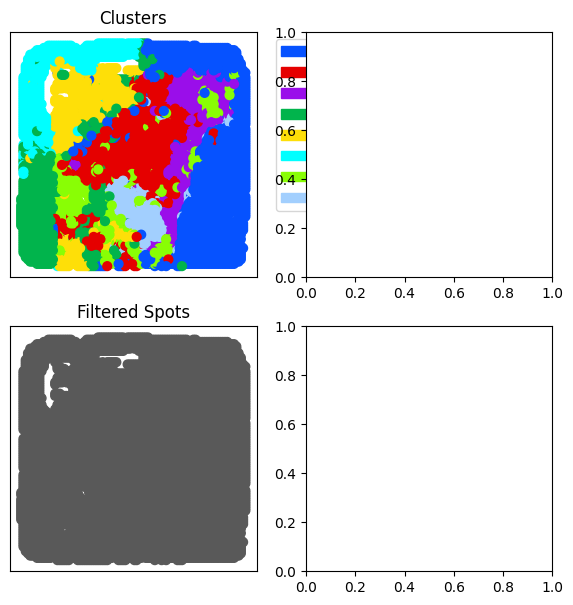

In [11]:
spatialcorr.analysis_pipeline_set(
    adata=merged_data_ann,  # The dataset
    genes=top10,            # The gene set                  
    cond_key='seurat_clusters',  # The key in `adata.obs` storing the cluster info
    max_perms=100,          # Maximum number of permutations to run
    row_key='y',
    col_key='x',
    dsize=40,               # Control the size of the dots
    verbose=0,              # Don't output any debugging information
)